In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from functools import partial
import random
#import cv2
from PIL import Image
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import copy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

%matplotlib inline

#### Carregar as fotos
Carrega a foto, reescalona (resize) e retorna o seu formato em RGB.

In [2]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

#### Carregar os pixels RGB da imagem

retorna um DataFrame com as coordenadas RGB da imagem.

In [3]:
def pick_pixels(photo):
    n , m = photo.size
    ibagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            ibagem.append(list(pixels[i,j]))
    return pd.DataFrame(ibagem)

#### Colorir a imagem
Colore a imagem com as respectivas cores dos centroides. 

In [4]:
def coloring(photo, labels, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            numb = [int(number) for number in centers[labels[i*m + j]] ] 
            pixels[i,j]= tuple(numb)
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

### Carregar dados

In [5]:
def import_data():
    data = loadmat('fcm_dataset.mat')
    data = pd.DataFrame(data['x'])
    lendata = len(data)
    print('Numero de obervacoes: ', lendata)
    nfeatures = data.shape[1]
    print('Numero de atributos (features): ', nfeatures)

    return data.values#.transpose()

def reduc_samples(X,n_samples=10):
    return X[:n_samples, :]

def plot_samples(x, u, centroids):
    y_kmeans = np.argmax(u, axis=1)
    plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.show()

def plot_samples3D(x, u, centroids):
    y_ = np.argmax(u, axis=1)
    target_names = ['Red','Green','Blue']
    colors = ['navy', 'turquoise', 'darkorange']
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2], 
                c=y_, cmap='viridis',
                edgecolor='k', s=40, alpha = 0.1)


    ax.set_title("RGB information Fuzzy Kmeans")
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    ax.dist = 10

    for cent in centroids:
        ax.scatter(cent[0],cent[1], cent[2], 
               s = 500, c = 'r', marker='*',alpha = 1.,label = 'Centroid')

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()

#### Algoritmo Fuzzy K means

In [6]:
def generate_u(k: int, n: int):
    return np.random.dirichlet(np.ones(k), size=n)


# returns array of K centroids
def calc_centroids(U, X, m):
    centroids = []
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    for i in range(n_centroids):
        u_i = U[:,i] 
        ui_m = u_i ** m

        features_cent = []
        n_feat_cent = int(X.shape[1])
        for feat in range(n_feat_cent):
            x_feat = X[:,feat]
            feat_cent = np.sum((ui_m*x_feat))/np.sum(ui_m) 
            features_cent.append(feat_cent)
        centroids.append(features_cent)

    centroids = np.array(centroids)
    return centroids


def calc_cost(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    cost = 0

    for i in range(n_centroids):
        for j in range(n_samples):
            dist = distance.euclidean(centroids[i], X[j,:])
            cost += (U[j][i] ** m) * (dist ** 2)

    return cost


def update_u(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    U_new = copy.copy(U)

    for j in range(n_samples):
        dist_kj = 0
        for k in range(n_centroids):
            dist_kj += distance.euclidean(centroids[k], X[j,:])
        for i in range(n_centroids):
            dist_ij = distance.euclidean(centroids[i], X[j,:])
            U_new[j][i] = 1 / (dist_ij / dist_kj) ** (2/(m - 1))
        #normaliza valores entre 0 e 1 para cada amostra
        sum_ = np.sum(U_new[j])
        U_new[j] = U_new[j]/sum_
    
    return U_new

# x: dataset composto de pontos no plano cartesiano (número de dimensões arbitrário)
# n_centroides: número desejado de clusters
# m: exponente de peso
def fuzzy_k_means(x, n_centroides, m, threshold = 0.001, max_inter = 10, plot='no' , log = False):
    if m <= 1:
        raise Exception(" 'm' should be greater than 1")

    u = generate_u(n_centroides, x.shape[0])
    cost = 1
    centroids = []
    iterations = 0
    while cost > threshold and iterations < max_inter:
        print('Interação {}'.format(iterations+1))
        centroids = calc_centroids(u, x, m)
        cost = calc_cost(u, x, centroids, m)
        u = update_u(u, x, centroids, m)
        iterations += 1
        print('Erro : {}'.format(cost))
        if log:
            print('Matrix centroids: {}'.format(centroids))
            print('Matrix U: {}'.format(u))
        if plot == '2D':
            plot_samples(x, u, centroids)
        elif plot == '3D':
            plot_samples3D(x, u, centroids)

    
    return {'centroids': centroids, 'u_matrix': u, 'n_iterations': iterations}

### Executando algoritmo para dados 2D

Numero de obervacoes:  800
Numero de atributos (features):  2
Interação 1
Erro : 204.8652483183953


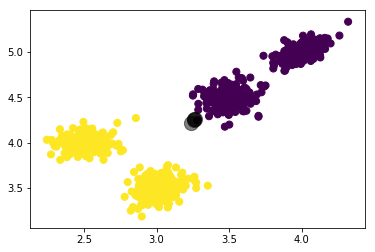

Interação 2
Erro : 127.16302324106191


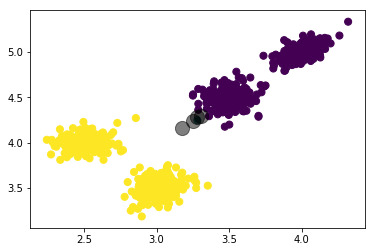

Interação 3
Erro : 120.54374785404198


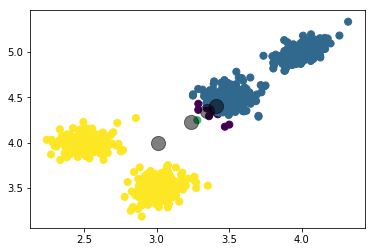

Interação 4
Erro : 90.13042964167217


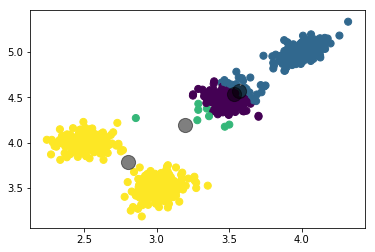

Interação 5
Erro : 66.19070673280115


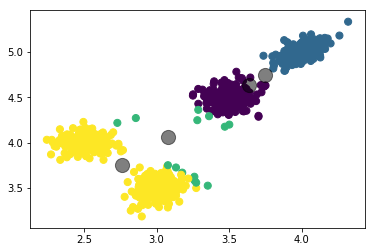

Interação 6
Erro : 50.99015954356323


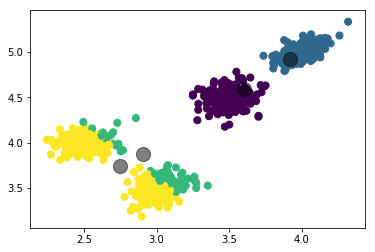

Interação 7
Erro : 34.01493566776086


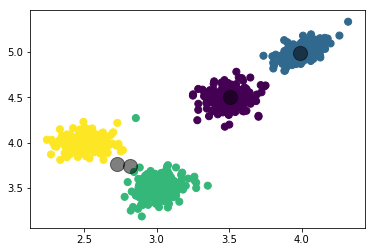

Interação 8
Erro : 29.985364835724518


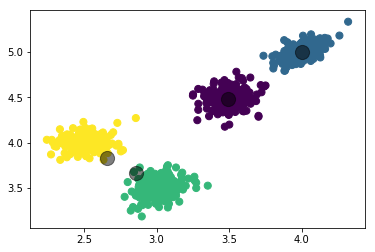

Interação 9
Erro : 18.336986048806637


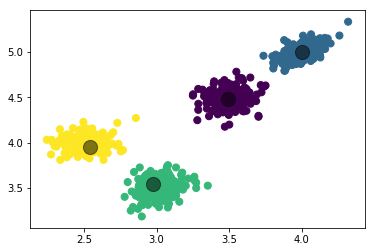

Interação 10
Erro : 12.537861543986203


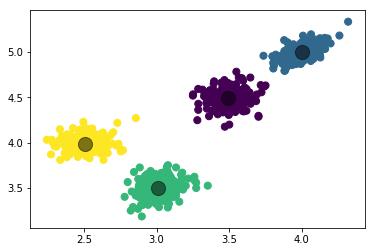

Interação 11
Erro : 12.434237136922842


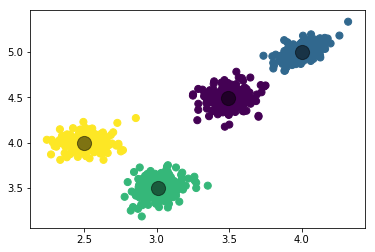

Interação 12
Erro : 12.433500288327458


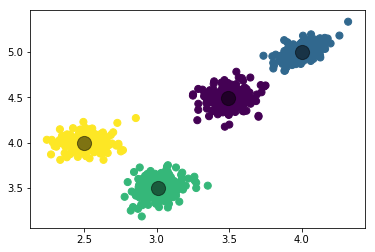

Interação 13
Erro : 12.433494580556323


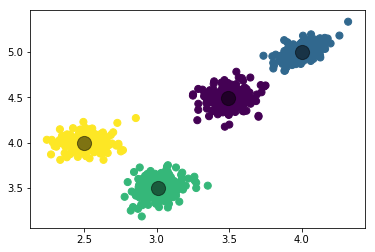

Resultado
Centroides: [[3.49398789 4.48756242]
 [4.00143286 5.00403969]
 [3.01197576 3.4998791 ]
 [2.50120862 3.99164096]]
Número de interações: 13
Matriz U: [[2.71435888e-02 9.62213179e-01 5.28460615e-03 5.35862650e-03]
 [1.20863537e-01 8.51087490e-01 1.36985317e-02 1.43504410e-02]
 [1.22037868e-02 9.84052756e-01 1.91126493e-03 1.83219182e-03]
 ...
 [1.17201620e-03 4.52997689e-04 2.89384901e-03 9.95481137e-01]
 [2.31224006e-03 9.03932431e-04 5.71222881e-03 9.91071599e-01]
 [9.96459933e-03 4.00903511e-03 2.08256046e-02 9.65200761e-01]]


In [7]:
X = import_data()
result = fuzzy_k_means(X, 4, 2, 0.1, 13, plot = '2D', log = False)
print('Resultado')
print('Centroides: {}'.format(result['centroids']))
print('Número de interações: {}'.format(result['n_iterations']))
print('Matriz U: {}'.format(result['u_matrix']))

### Execução do algoritmo
Isto deve ser feito para cada imagem



Load and Preprocessing image: photo009.jpg...


Real image:


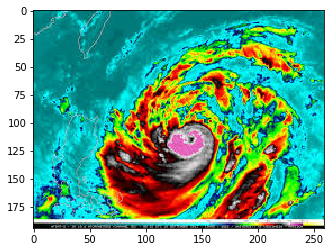

Size pixels: (50246, 3)

Running Fuzzy kmeans for photo009.jpg

Interação 1
Erro : 416189039.1012188
Interação 2
Erro : 260570034.42055455
Interação 3
Erro : 260480574.33888987
Interação 4
Erro : 260016606.41706526
Interação 5
Erro : 257717305.87147862
Interação 6
Erro : 248398691.96260342
Interação 7
Erro : 227570239.92821494
Interação 8
Erro : 209766812.40501943
Interação 9
Erro : 202704313.44759265
Interação 10
Erro : 196721089.5879384
Result Fuzzy kmeans RGB:



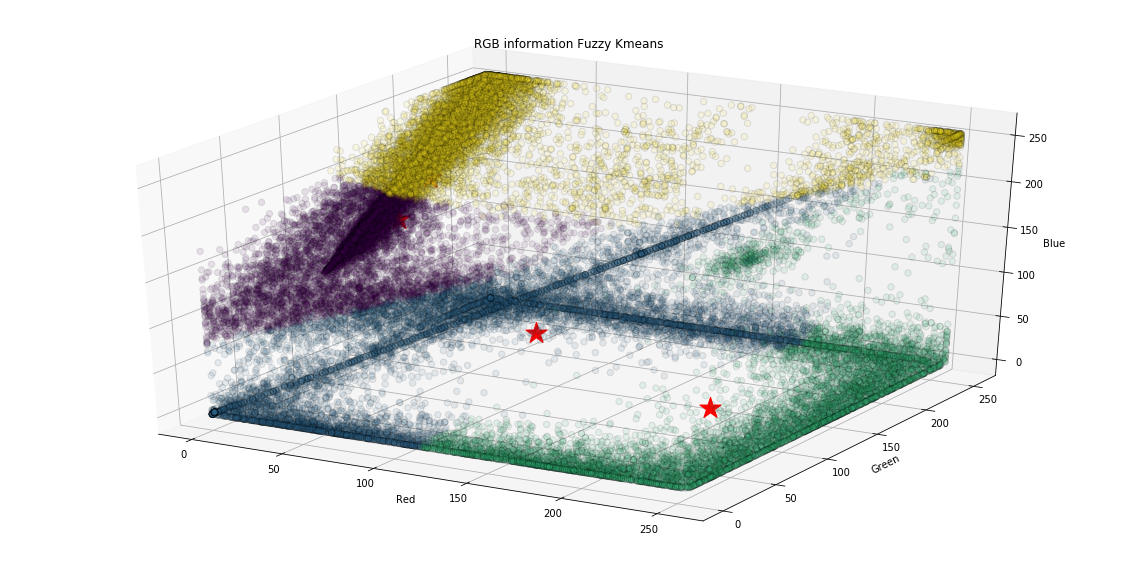



Result for image photo009.jpg



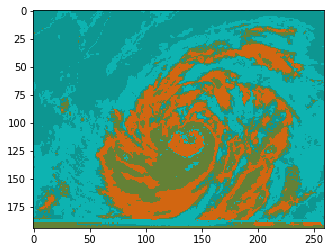



Load and Preprocessing image: photo004.jpg...


Real image:


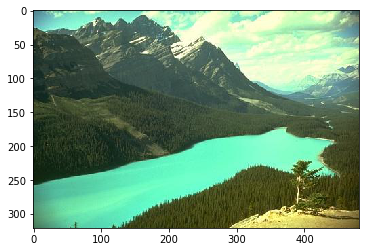

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo004.jpg

Interação 1
Erro : 946303144.4695075
Interação 2
Erro : 590974927.0543456
Interação 3
Erro : 590400535.4267683
Interação 4
Erro : 583341524.0604831
Interação 5
Erro : 513223360.89144105
Interação 6
Erro : 284077424.04159063
Interação 7
Erro : 204383699.57589203
Interação 8
Erro : 190654484.0003348
Interação 9
Erro : 167862783.59552425
Interação 10
Erro : 140953030.8638759
Result Fuzzy kmeans RGB:



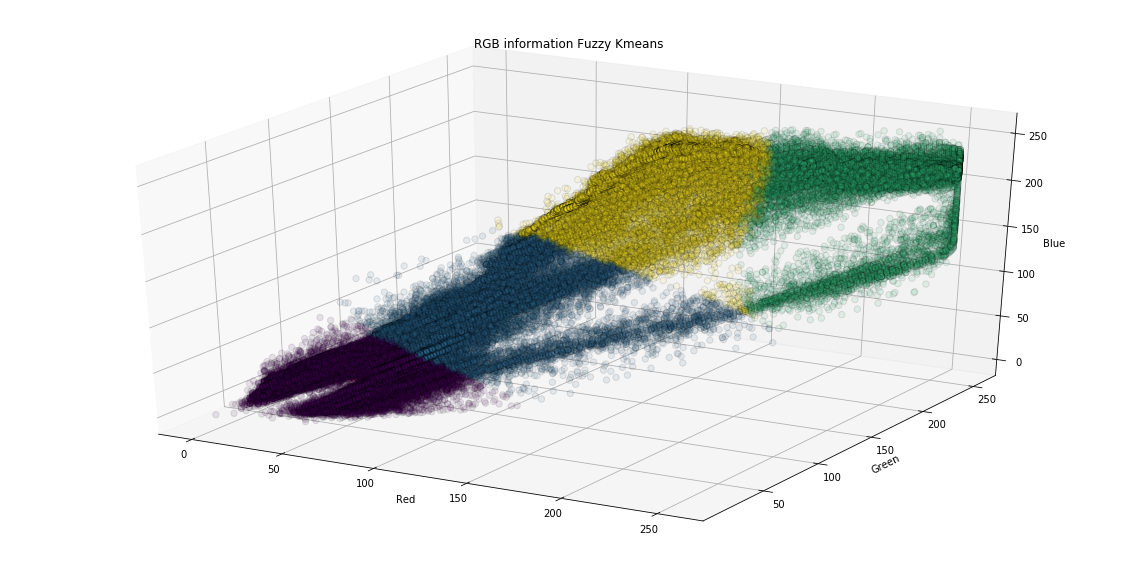



Result for image photo004.jpg



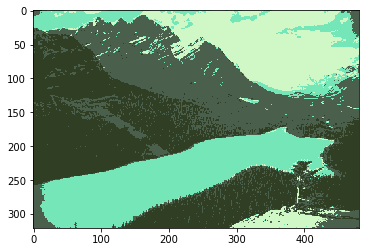



Load and Preprocessing image: photo006.jpg...


Real image:


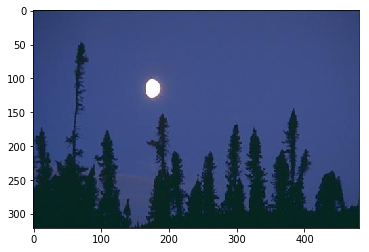

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo006.jpg

Interação 1
Erro : 173585560.0327139
Interação 2
Erro : 108344957.71135725
Interação 3
Erro : 108217908.06671657
Interação 4
Erro : 106392495.01174043
Interação 5
Erro : 87199211.53990997
Interação 6
Erro : 35779185.08827382
Interação 7
Erro : 20727729.943197403
Interação 8
Erro : 19926602.949724812
Interação 9
Erro : 19861901.729870815
Interação 10
Erro : 19839935.90741865
Result Fuzzy kmeans RGB:



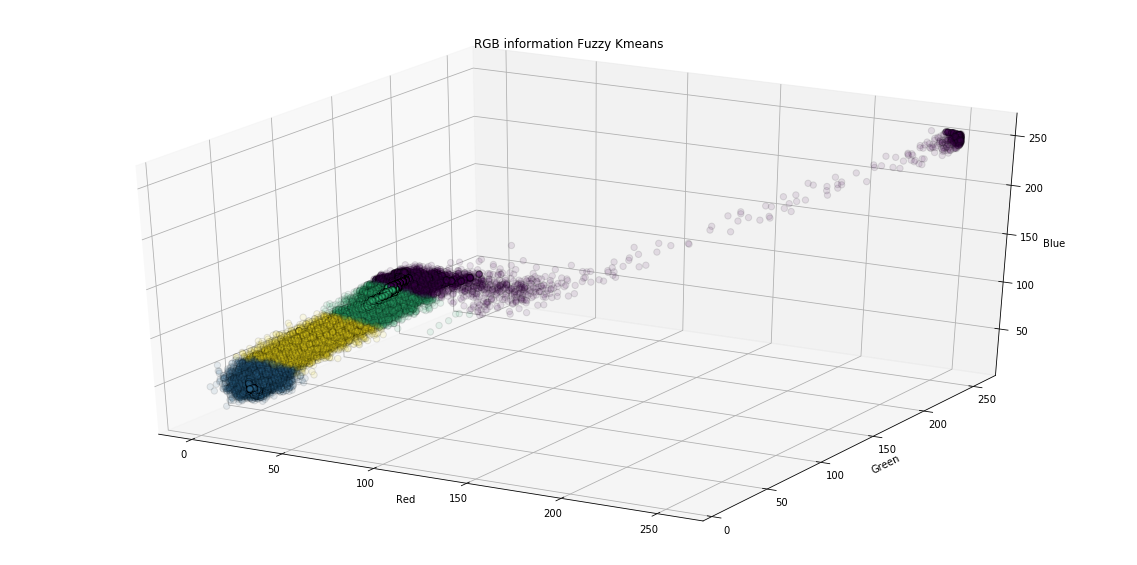



Result for image photo006.jpg



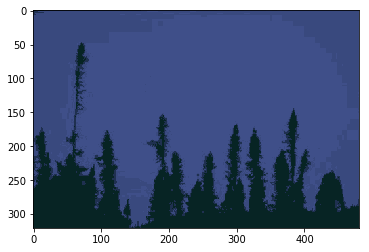



Load and Preprocessing image: photo007.jpg...


Real image:


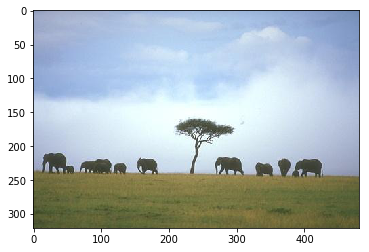

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo007.jpg

Interação 1
Erro : 666589180.6760879
Interação 2
Erro : 416783062.9758579
Interação 3
Erro : 415765910.59284157
Interação 4
Erro : 404663422.77421165
Interação 5
Erro : 322283452.76957923
Interação 6
Erro : 148762036.7530377
Interação 7
Erro : 91285141.18301734
Interação 8
Erro : 80923008.13422108
Interação 9
Erro : 77178043.12567946
Interação 10
Erro : 74959432.22625917
Result Fuzzy kmeans RGB:



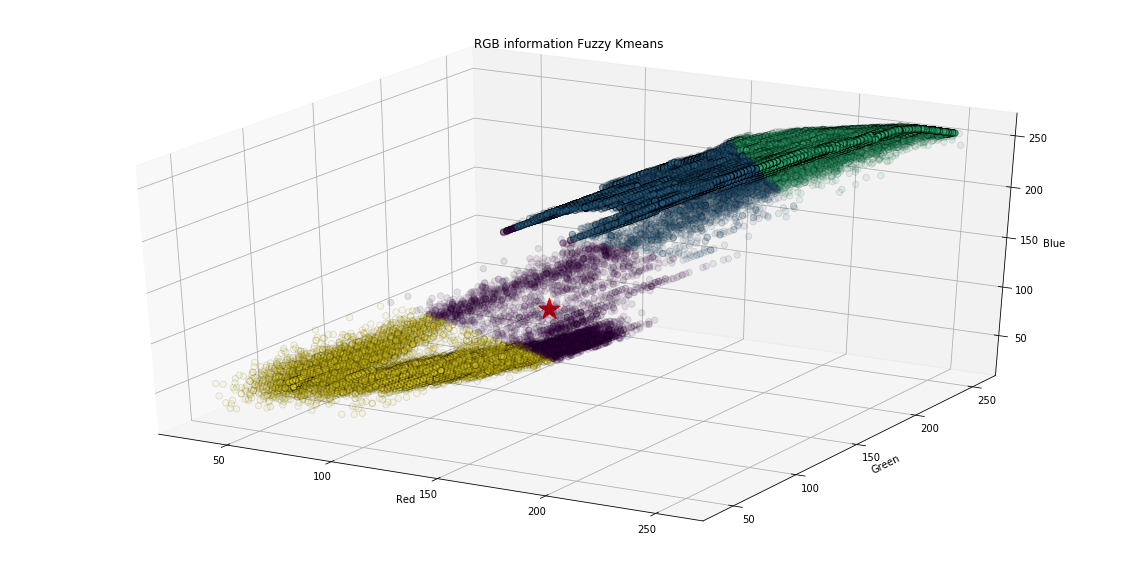



Result for image photo007.jpg



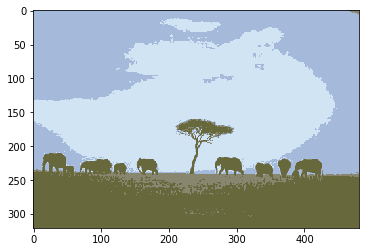



Load and Preprocessing image: photo008.jpg...


Real image:


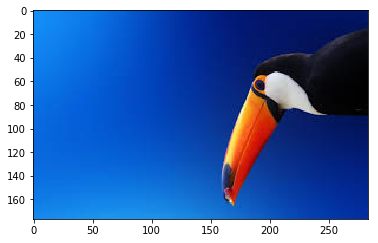

Size pixels: (50268, 3)

Running Fuzzy kmeans for photo008.jpg

Interação 1
Erro : 174708164.69311997
Interação 2
Erro : 109324670.74379054
Interação 3
Erro : 109194996.84384602
Interação 4
Erro : 108110183.76961759
Interação 5
Erro : 101287988.6939199
Interação 6
Erro : 84749480.77542298
Interação 7
Erro : 75821273.5382552
Interação 8
Erro : 72369635.58971372
Interação 9
Erro : 70354215.35098602
Interação 10
Erro : 69313987.60937712
Result Fuzzy kmeans RGB:



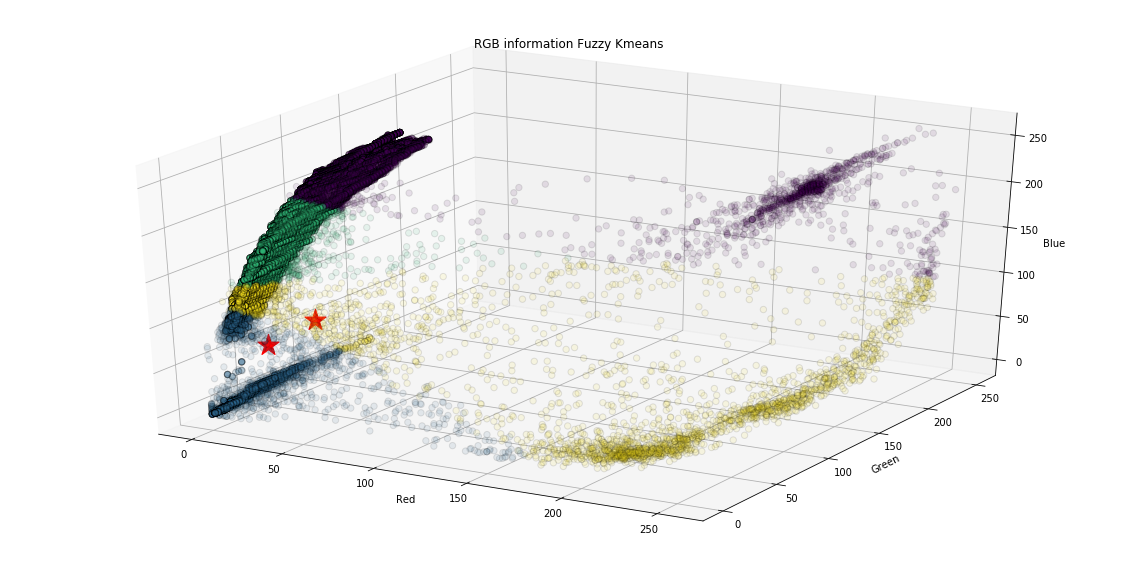



Result for image photo008.jpg



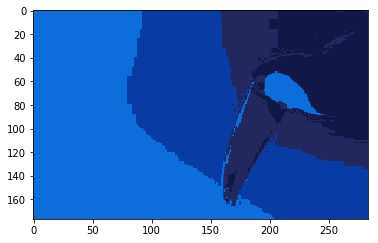



Load and Preprocessing image: photo002.jpg...


Real image:


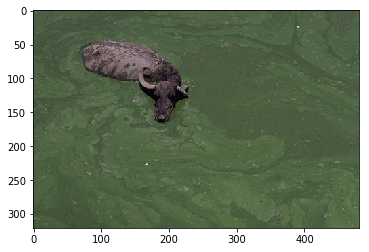

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo002.jpg

Interação 1
Erro : 27764629.52659949
Interação 2
Erro : 17373809.94300254
Interação 3
Erro : 17365042.500975635
Interação 4
Erro : 17290896.64651058
Interação 5
Erro : 16846927.886676695
Interação 6
Erro : 15853366.86855648
Interação 7
Erro : 15122379.962233163
Interação 8
Erro : 14598472.230999382
Interação 9
Erro : 14226206.359821273
Interação 10
Erro : 14026324.110343823
Result Fuzzy kmeans RGB:



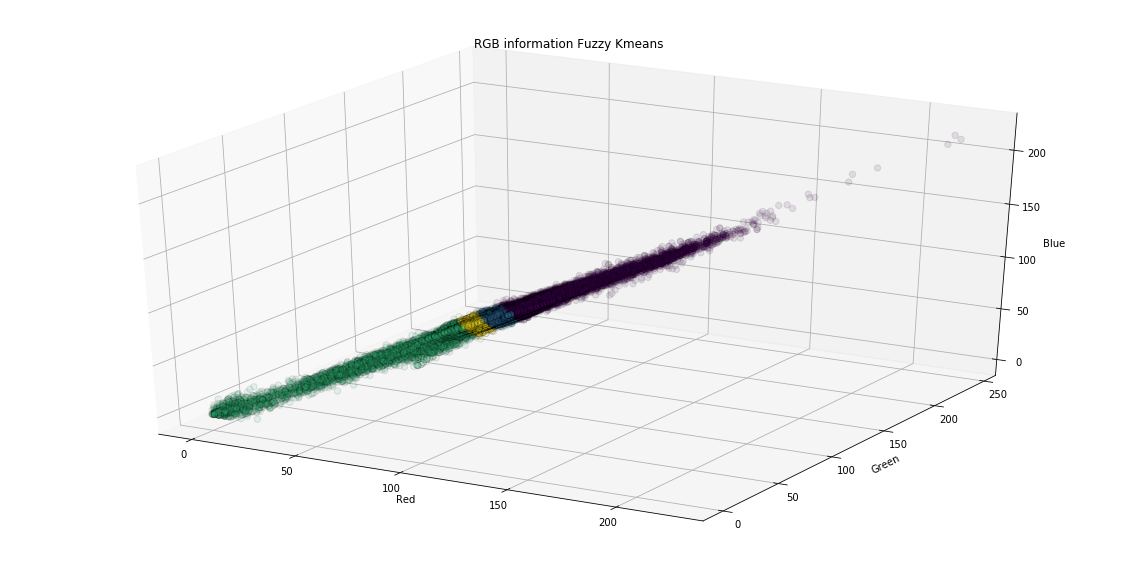



Result for image photo002.jpg



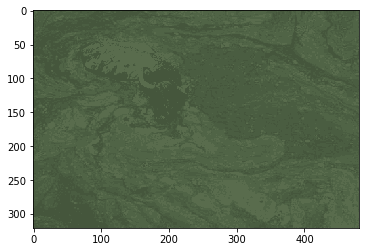



Load and Preprocessing image: photo010.jpg...


Real image:


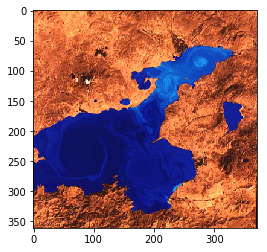

Size pixels: (133931, 3)

Running Fuzzy kmeans for photo010.jpg

Interação 1
Erro : 692002076.0689834
Interação 2
Erro : 432485789.9625382
Interação 3
Erro : 432363890.516808
Interação 4
Erro : 431284427.5165306
Interação 5
Erro : 422153556.8552131
Interação 6
Erro : 364315248.60539347
Interação 7
Erro : 237760286.2737582
Interação 8
Erro : 177355454.26351404
Interação 9
Erro : 153415745.42706764
Interação 10
Erro : 147671424.3389671
Result Fuzzy kmeans RGB:



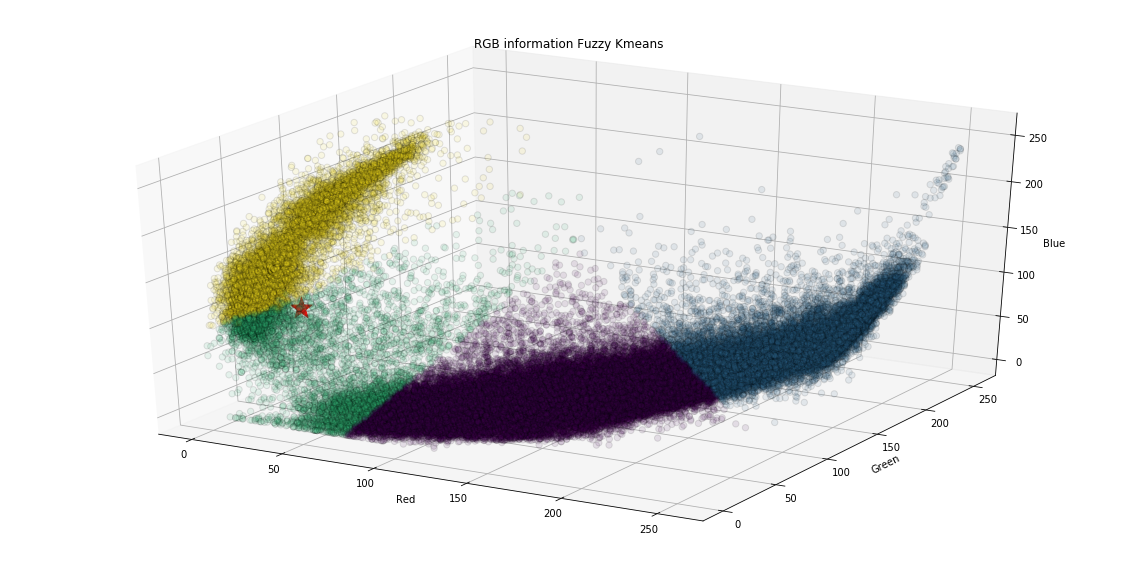



Result for image photo010.jpg



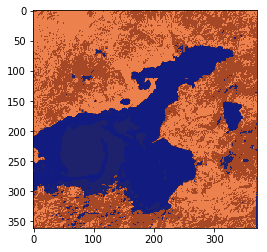



Load and Preprocessing image: photo003.jpg...


Real image:


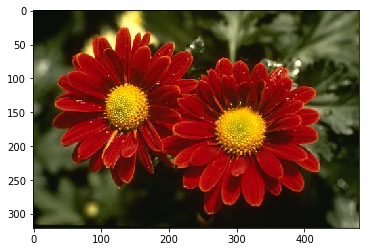

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo003.jpg

Interação 1
Erro : 446157043.9929373
Interação 2
Erro : 278943938.00053173
Interação 3
Erro : 278900335.895905
Interação 4
Erro : 278681451.71169007
Interação 5
Erro : 277585322.8905576
Interação 6
Erro : 272484245.19360507
Interação 7
Erro : 255290704.93254998
Interação 8
Erro : 229176231.11856252
Interação 9
Erro : 202120428.7096555
Interação 10
Erro : 170955679.69447285
Result Fuzzy kmeans RGB:



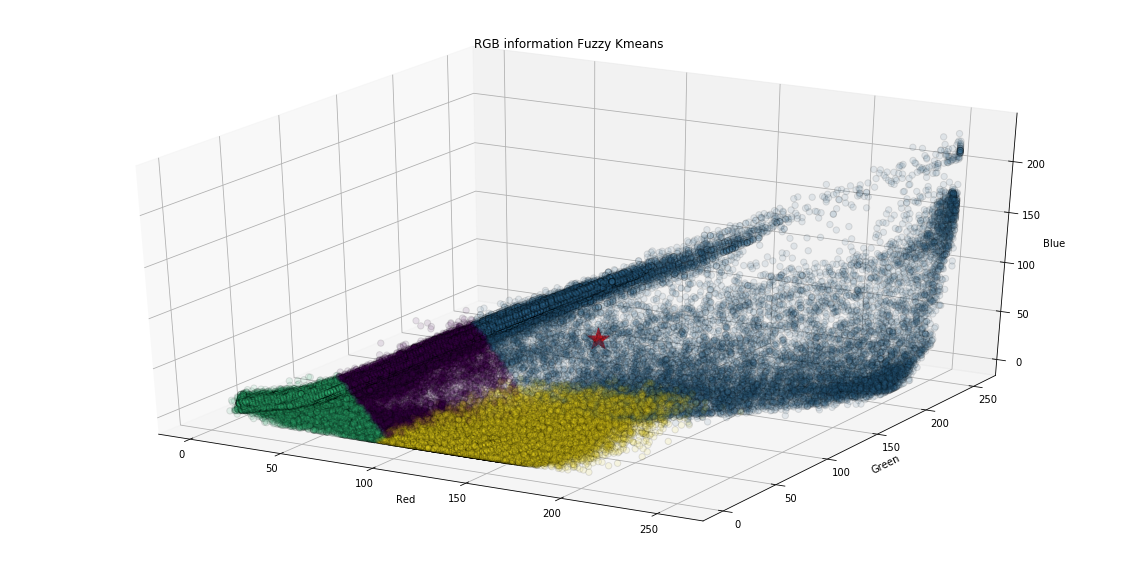



Result for image photo003.jpg



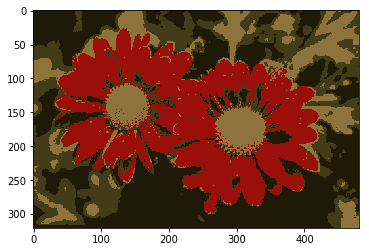



Load and Preprocessing image: photo005.jpg...


Real image:


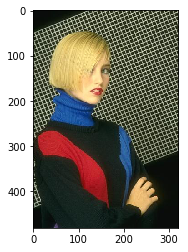

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo005.jpg

Interação 1
Erro : 786200596.2283393
Interação 2
Erro : 491202327.2509574
Interação 3
Erro : 490669543.6365549
Interação 4
Erro : 484655328.9326532
Interação 5
Erro : 430995410.8655434
Interação 6
Erro : 260319015.4744734
Interação 7
Erro : 191092883.09967172
Interação 8
Erro : 172722079.7980893
Interação 9
Erro : 166390279.77359843
Interação 10
Erro : 160666409.97318438
Result Fuzzy kmeans RGB:



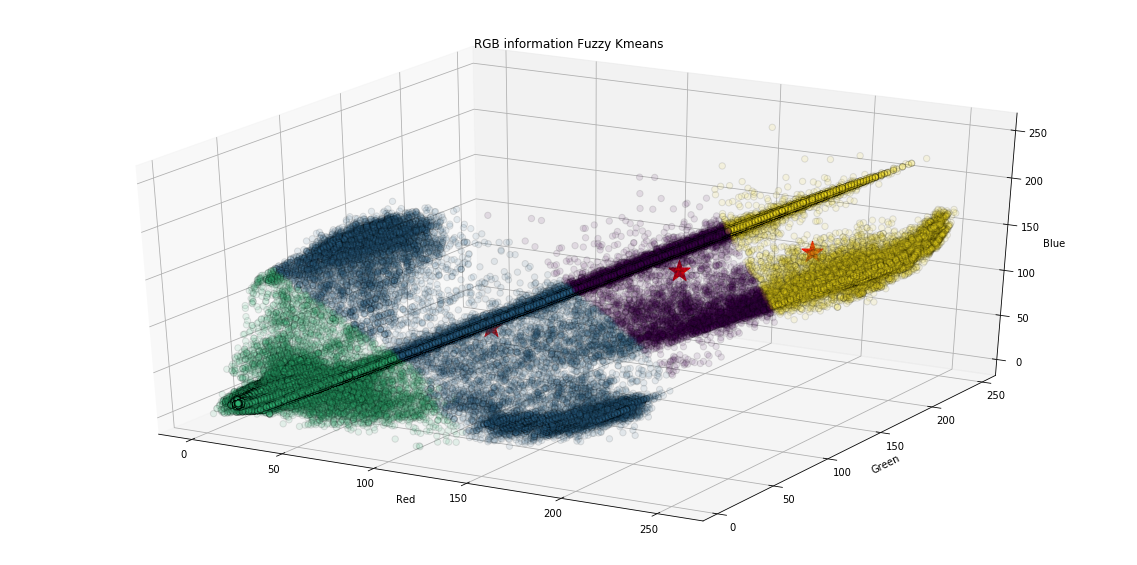



Result for image photo005.jpg



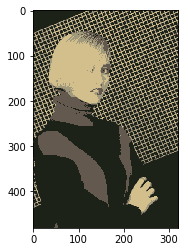



Load and Preprocessing image: photo001.jpg...


Real image:


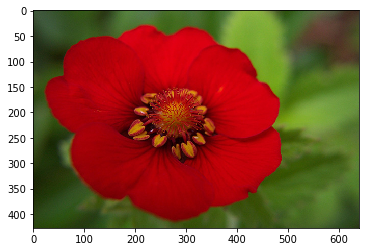

Size pixels: (273280, 3)

Running Fuzzy kmeans for photo001.jpg

Interação 1
Erro : 697122952.3706563
Interação 2
Erro : 435461048.8131122
Interação 3
Erro : 435300479.7870717
Interação 4
Erro : 433712238.49038124
Interação 5
Erro : 418776853.53778034
Interação 6
Erro : 324848089.7957897
Interação 7
Erro : 209631172.0870055
Interação 8
Erro : 200807572.93964365
Interação 9
Erro : 197660562.96736658
Interação 10
Erro : 188803272.21796265
Result Fuzzy kmeans RGB:



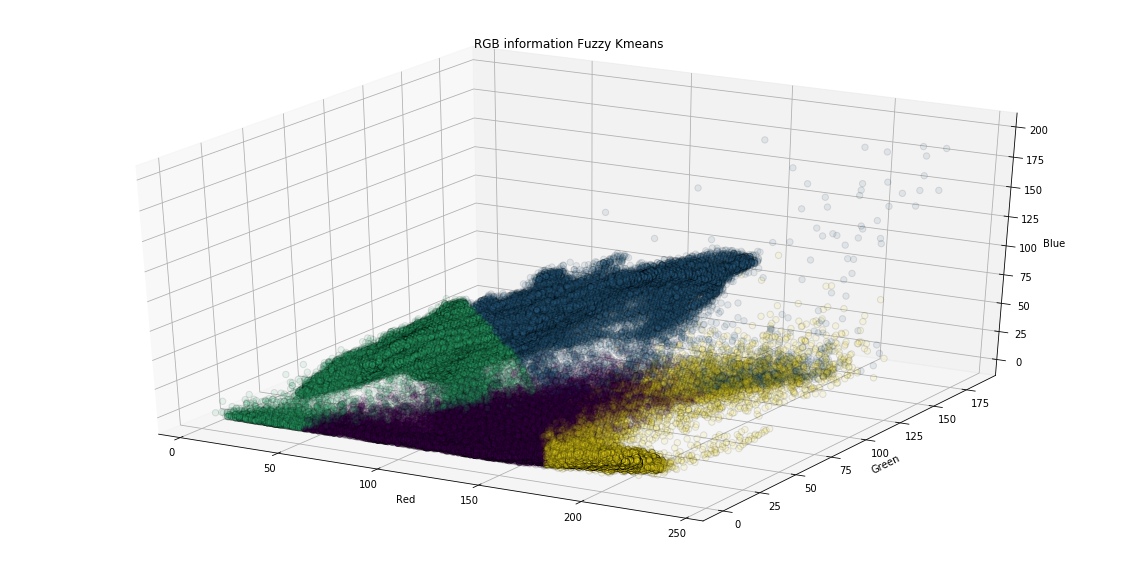



Result for image photo001.jpg



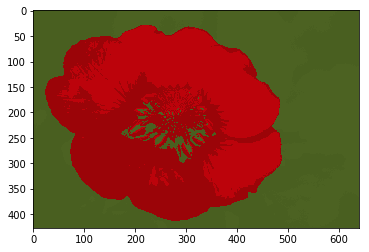



Load and Preprocessing image: photo011.png...


Real image:


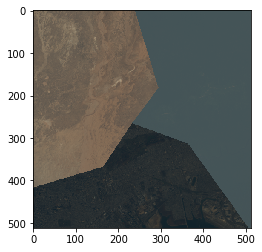

Size pixels: (262144, 3)

Running Fuzzy kmeans for photo011.png

Interação 1
Erro : 206944502.61339122
Interação 2
Erro : 129335801.1714252
Interação 3
Erro : 129334671.98350398
Interação 4
Erro : 129327470.61882272
Interação 5
Erro : 129281552.14817466
Interação 6
Erro : 128988045.93080007
Interação 7
Erro : 127062955.99873672
Interação 8
Erro : 113766849.28502464
Interação 9
Erro : 59585713.00107978
Interação 10
Erro : 20080647.711486135
Result Fuzzy kmeans RGB:



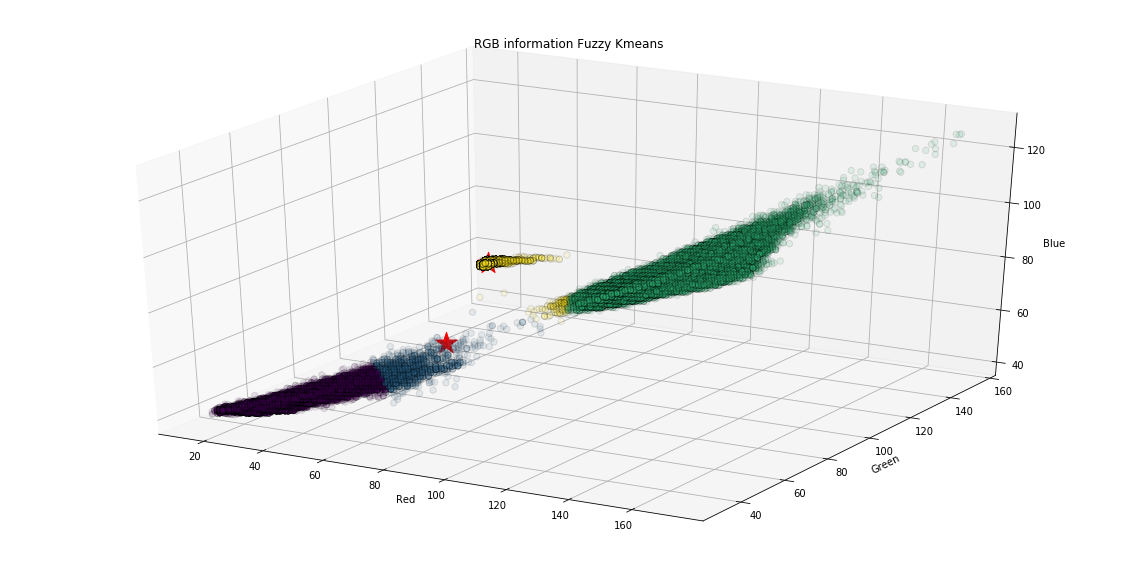



Result for image photo011.png



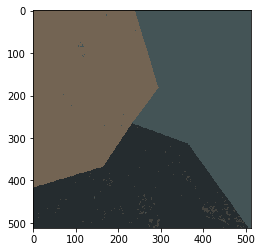

In [8]:
path_images = './../ImagensTeste/'
filenames = os.listdir(path_images)
n_inter = 10
error_acc = 0.1
k = 4 #def
m = 2 
log = False

for filename in filenames:
    print('\n\nLoad and Preprocessing image: {}...\n'.format(filename))
    #load image and transform in vector RGB
    photo = photo_open(path_images+filename)
    print('\nReal image:')
    plt.imshow(photo)
    plt.show()
    pixels = pick_pixels(photo).values
    print('Size pixels: {}\n'.format(pixels.shape))
    #running the Fuzzy kmeans algorithm
    print('Running Fuzzy kmeans for {}\n'.format(filename))
    result = fuzzy_k_means(pixels, k, m, error_acc, n_inter, plot = 'no', log = log)
    #Plot result de categorização do algoritmo
    print('Result Fuzzy kmeans RGB:\n')
    plot_samples3D(pixels, result['u_matrix'], result['centroids'])
    #transforma de valores retornados pelo fuzzy em um vetor de labels
    print('\n\nResult for image {}\n'.format(filename))
    labels = np.argmax(result['u_matrix'],axis=1)
    centers = result['centroids']
    photo = coloring(photo, labels, centers)
    #Plot result
    plt.imshow(photo)
    plt.show()